## Importing Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.svm import SVR

from yellowbrick.cluster import KElbowVisualizer

## Loading Data

In [3]:
data = pd.read_csv('data.csv', encoding='latin-1')
data.dropna()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data['Revenue'] = data.apply(lambda i: i['Quantity'] * i['UnitPrice'], axis=1)

In [56]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year


## Exploring Data

**To knew more about data, we need to answer the follwing questions:**
1. What was the total revenue?
2. Which months had the higher sales?
3. What products are in the top 10 in sales and revenue?
4. Which products were returned more frequently?
5. What are the top 10 countries that purchased the most?
6. How much is the share of the revenue for each cluster?


**Total revenue**


In [7]:
total_revenue = data['Revenue'].sum()
total_revenue

9747747.933999998

**Months` sales**

In [8]:
total_per_month = data.groupby(['Year','Month'])['Revenue'].sum()

<AxesSubplot:xlabel='Year,Month'>

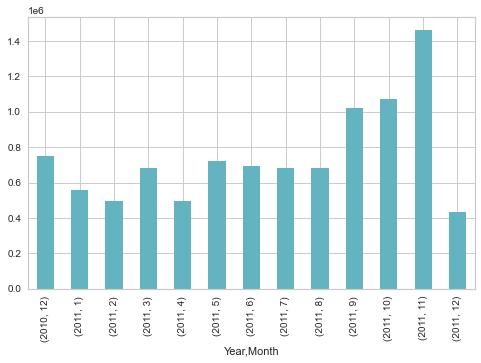

In [9]:
total_per_month.plot(kind='bar', color='#63b3c0',figsize=(8,5))

**Products Sales**

Top *`n`* products in sales

In [10]:
most_popular_products = data[['StockCode','Description','Quantity','Revenue']].groupby('StockCode', as_index=False).sum(['Quantity','Revenue']).sort_values(by='Quantity', ascending=False)

[Text(0.5, 1.0, 'Top 10 products in sales')]

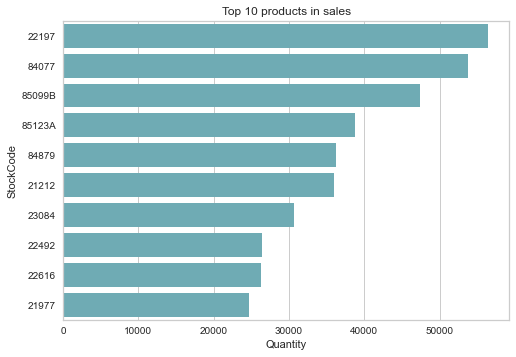

In [11]:
sns.barplot(x='Quantity', y='StockCode', data=most_popular_products.head(10), color='#63b3c0').set(title='Top 10 products in sales')

Top 10 products in revenue

In [12]:
most_revenue = most_popular_products.sort_values(by='Revenue', ascending=False)

[Text(0.5, 1.0, 'Top 10 products in revenue')]

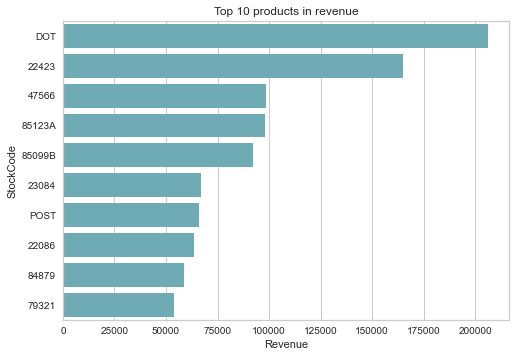

In [13]:
sns.barplot(x='Revenue', y='StockCode', data=most_revenue.head(10), color='#63b3c0').set(title='Top 10 products in revenue')

Products were returned more frequently

In [14]:
most_returned_products = data[
                              ['StockCode','Description','Quantity','Revenue']
                              ].loc[data['Revenue'] < 0].sort_values(by='Revenue', ascending=True)

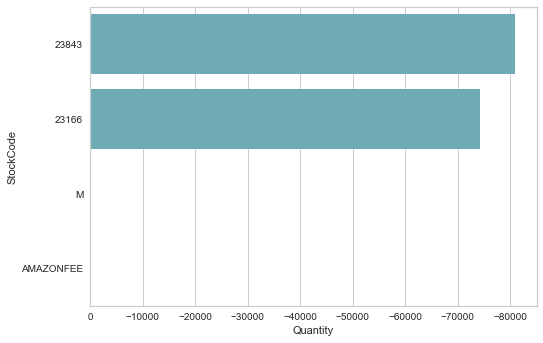

In [15]:
sns.barplot(x='Quantity',y='StockCode', data=most_returned_products.head(10), color='#63b3c0')
plt.gca().invert_xaxis()

**Most Consumed Country**

In [16]:
most_countries = data[['Country','Quantity','Revenue']].groupby(['Country'], as_index=False).sum().sort_values(by='Quantity',ascending=False)

<AxesSubplot:xlabel='Revenue', ylabel='Country'>

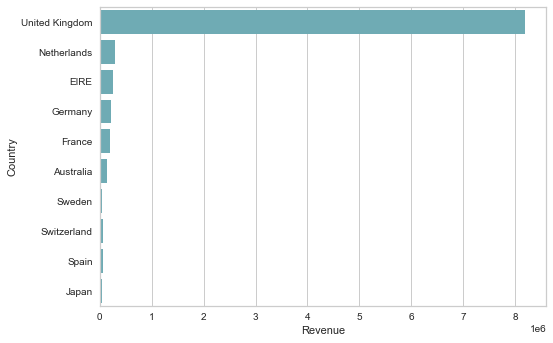

In [17]:
sns.barplot(y='Country', x='Revenue', data=most_countries.head(10), color='#63b3c0')

**Revenue share for each cluster**

In [18]:
customers = pd.DataFrame(data.groupby('CustomerID')['Revenue'].sum()).sort_values('Revenue', ascending=False)

In [19]:
revenues = customers['Revenue']
minn = revenues.min()
maxx = revenues.max()
n = (maxx - minn) // 5

In [20]:
g1 = customers[revenues < minn + n ] 
g2 = customers[(revenues >= minn + n) & (revenues >= minn + 2*n)]
g3 = customers[(revenues >= minn + 2*n) & (revenues >= minn + 3*n)]
g4 = customers[(revenues >= minn + 3*n) & (revenues >= minn + 4*n)]
g5 = customers[(revenues >= minn + 4*n)]

In [21]:
def custom_labels(b, inc, n):
  lst = []
  prepare_num = lambda number: int((b + number * inc) / 1000)
  for i in range(1, n):
    num = prepare_num(i)
    if i == 1:
      lst.append(f'Bellow {num}k')
    elif i == n-1:
      lst.append(f'Above {num}k')
    else:
      lst.append(f'Within ({prepare_num(i-1)}k, {num}k)')
  return lst

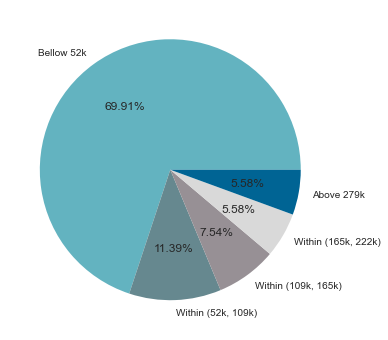

In [22]:
labels = custom_labels(minn, n, 6)
sns.set_palette(sns.color_palette(['#63b3c0','#66888f','#979095','#d9d9d9', '#006494']))
plt.figure(figsize =(10, 6))
pie_data = [i['Revenue'].sum() for i in (g1, g2, g3, g4, g5)]
plt.pie(pie_data, labels = labels, autopct='%1.2f%%')
plt.show()

**Correlation od data coulmns**

## Preparing Data

1. Setup the data with required columns
2. Removing the outliers
3. Correlation bettween the selected featuers
4. Split data into train set & test set
5. Scaling using minmax scaler



In [23]:
customers = pd.DataFrame(data.groupby('CustomerID')['Revenue'].sum()).sort_values('Revenue', ascending=False)
customers['Purchases'] = data.groupby('CustomerID')['InvoiceNo'].count()
customers['Quantity'] = data.groupby('CustomerID')['Quantity'].sum()
customers['RevenuePercentage'] = customers.apply(lambda i: i['Revenue'] / total_revenue, axis=1)

subset = customers.copy()
subset.reset_index(inplace=True)
subset.head()

,CustomerID,Revenue,Purchases,Quantity,RevenuePercentage
0,14646.0,279489.02,2085,196719,0.028672
1,18102.0,256438.49,433,64122,0.026307
2,17450.0,187482.17,351,69029,0.019233
3,14911.0,132572.62,5903,77180,0.013600
4,12415.0,123725.45,778,77242,0.012693


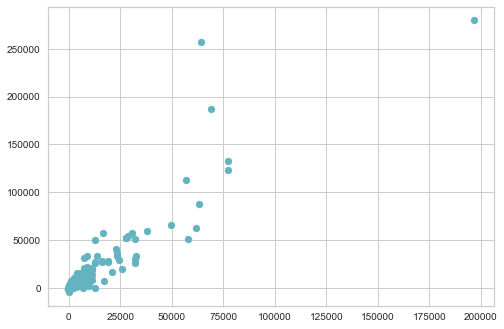

In [24]:
plt.scatter(subset['Quantity'], subset['Revenue'])
plt.show()

**Removing the outliers with Quartiles**

In [25]:
Q1 = np.percentile(subset['Quantity'], 25, interpolation = 'midpoint')
Q3 = np.percentile(subset['Quantity'], 75, interpolation = 'midpoint')

IQR = Q3 - Q1

In [26]:
upper = np.where(subset['Quantity'] >= (Q3 + 1.5*IQR))
lower = np.where(subset['Quantity'] <= (Q1 - 1.5*IQR))
 
subset.drop(upper[0], inplace = True)
subset.drop(lower[0], inplace = True)

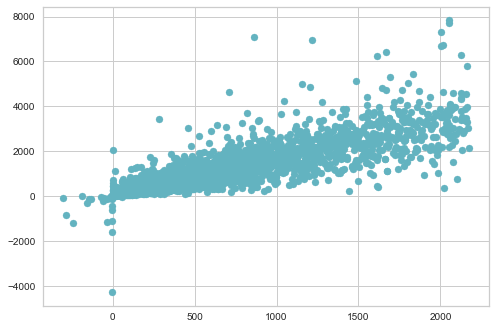

In [27]:
plt.scatter(subset['Quantity'], subset['Revenue'])
plt.show()

**Correlation bettween the selected featuers** 

In [28]:
subset['Quantity'].corr(subset['Revenue'])

0.8664743082485633

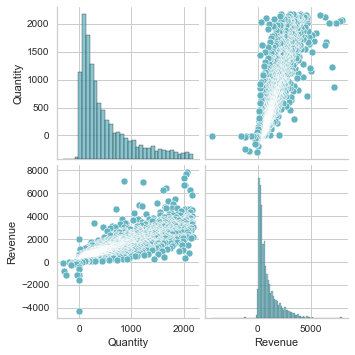

In [29]:
sns.pairplot(subset[['Quantity', 'Revenue']])
plt.show()

**Spliting Data**

In [30]:
x = subset[['Revenue', 'Quantity']]
x_train, x_test = train_test_split(x, test_size=0.33, random_state=42)

**Scaling using minmax scaler**


In [31]:
# Quantity
revenue_scaler = MinMaxScaler()
revenue_scaler.fit(x_train[['Revenue']])
x_train['RevenueScaled'] = revenue_scaler.transform(x_train[['Revenue']])
x_test['RevenueScaled'] = revenue_scaler.transform(x_test[['Revenue']])

# Revenue
quantity_scaler = MinMaxScaler()
quantity_scaler.fit(x_train[['Quantity']])
x_train['QuantityScaled'] = quantity_scaler.transform(x_train[['Quantity']])
x_test['QuantityScaled'] = quantity_scaler.transform(x_test[['Quantity']])

In [32]:
x_train.head()

,Revenue,Quantity,RevenueScaled,QuantityScaled
2621,465.68,305,0.396142,0.245657
2061,702.79,898,0.415903,0.485253
797,2166.38,1401,0.537879,0.688485
4150,101.34,106,0.365778,0.165253
3153,316.68,185,0.383724,0.197172


In [33]:
x_test.head()

,Revenue,Quantity,RevenueScaled,QuantityScaled
511,3102.42,1116,0.615888,0.573333
2173,653.13,261,0.411764,0.227879
4047,120.90,198,0.367408,0.202424
1119,1558.72,631,0.487236,0.377374
710,2398.86,1560,0.557253,0.752727


In [34]:
train_points = x_train[['RevenueScaled', 'QuantityScaled']].to_numpy()
test_points = x_test[['RevenueScaled', 'QuantityScaled']].to_numpy()

## KMeans clustering
1. Determine optimal cluster number with Elbow method
2. Fiting KMeans Model
3. Plotting the Result

**Determine optimal cluster number with Elbow method** <br>
Given inertia formula: <br>
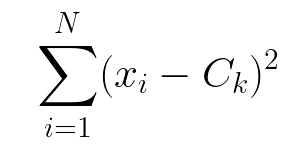

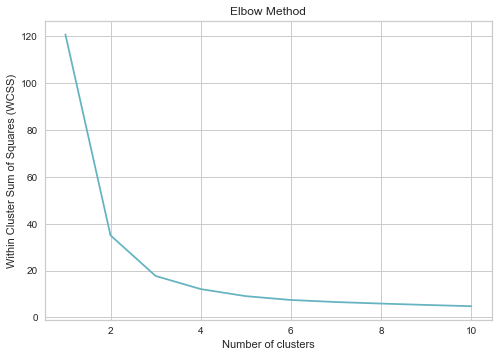

In [35]:
WCSS = []

for i in range(1, 11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',                 # Initialization method for kmeans
                    max_iter = 300,                     # Maximum number of iterations 
                    n_init = 10,                        # Choose how often algorithm will run with different centroid 
                    random_state = 0)                   # Choose random state for reproducibility
    model.fit(train_points)                              
    WCSS.append(model.inertia_)                         # Kmeans inertia_ :  Sum of squared distances of samples to their closest cluster center.
    
plt.plot(range(1, 11), WCSS)
plt.title('Elbow Method')                              
plt.xlabel('Number of clusters')                        
plt.ylabel('Within Cluster Sum of Squares (WCSS)')     
plt.show()

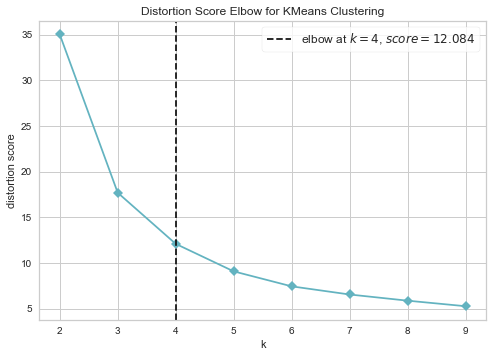

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 10), timings=False)
visualizer.fit(train_points)
visualizer.show()

**Fiting KMeans Model** <br>
Given the formula <br>
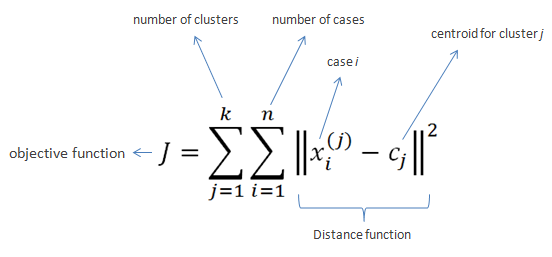

In [37]:
K = 4
KMeansModel = KMeans(n_clusters=K, init='k-means++', random_state=0)
KMeansModel.fit(train_points)

KMeans(n_clusters=4, random_state=0)

In [38]:
kmeans_predicted = KMeansModel.predict(test_points)

In [39]:
centers = KMeansModel.cluster_centers_
centers

array([[0.38145145, 0.18101653],
       [0.59256913, 0.79888929],
       [0.42772828, 0.31293894],
       [0.49420702, 0.50918886]])

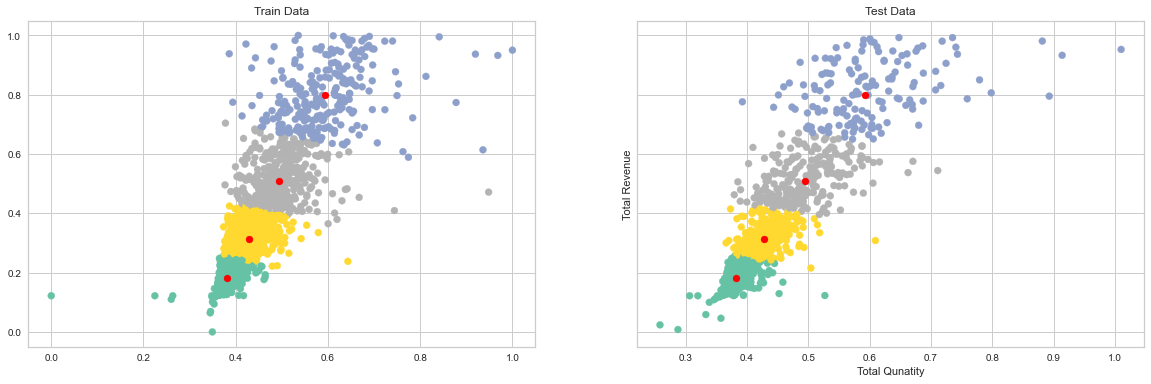

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))

ax1.set_title('Train Data')
ax1.scatter(train_points[:, 0], train_points[:, 1], c=KMeansModel.labels_, cmap='Set2')
ax1.scatter(centers[:, 0], centers[:, 1], c='red')

ax2.set_title('Test Data')
ax2.scatter(test_points[:, 0], test_points[:, 1], c=kmeans_predicted, cmap='Set2')
ax2.scatter(centers[:, 0], centers[:, 1], c='red')

plt.xlabel('Total Qunatity')
plt.ylabel('Total Revenue')
plt.show()

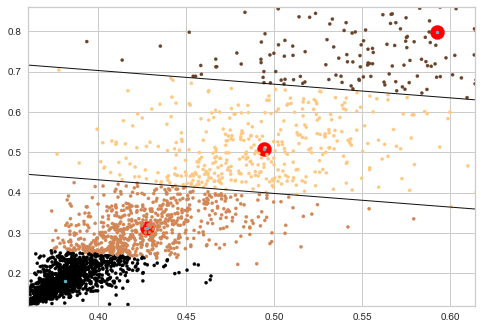

In [41]:
from scipy.spatial import Voronoi, voronoi_plot_2d 

vor = Voronoi(centers) 
voronoi_plot_2d(vor) 
plt.scatter(centers[:, 0],centers[:, 1], s=200, c='red')
plt.scatter(train_points[:, 0], train_points[:, 1], c=KMeansModel.labels_,  s=10, cmap='copper')
plt.show()

In [42]:
kmeans_points = pd.DataFrame(
    x_train['QuantityScaled'].append(x_test['QuantityScaled']),
    columns=['QuantityScaled',]
    )
kmeans_points['RevenueyScaled'] = x_train['QuantityScaled'].append(x_test['QuantityScaled'])
kmeans_points['KMeans'] = np.concatenate((KMeansModel.labels_, kmeans_predicted))

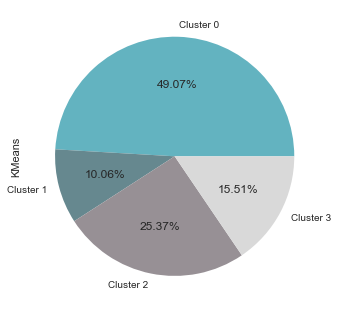

In [43]:
kmeans_points.groupby('KMeans')['KMeans'].count().plot.pie(labels=[f'Cluster {i}' for i in range(K)], autopct='%1.2f%%')
plt.show()

## Agglomerative Clustering
1. Determine optimal cluster number with Elbow method
2. Fiting Agglomerative Model Model
3. Plotting the result


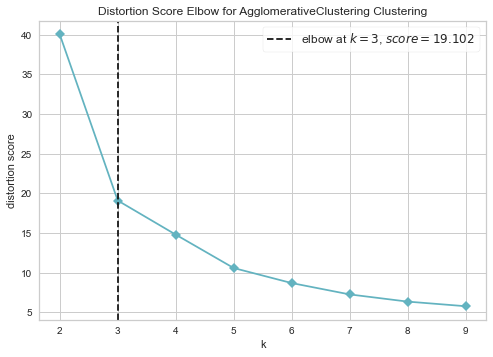

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2, 10), timings=False)
visualizer.fit(train_points)
visualizer.show()

In [58]:
K = 3
AggModel_train = AgglomerativeClustering(n_clusters=K, affinity = 'euclidean', linkage = 'ward', compute_distances=True)
AggModel_train.fit(train_points)

AgglomerativeClustering(compute_distances=True, n_clusters=3)

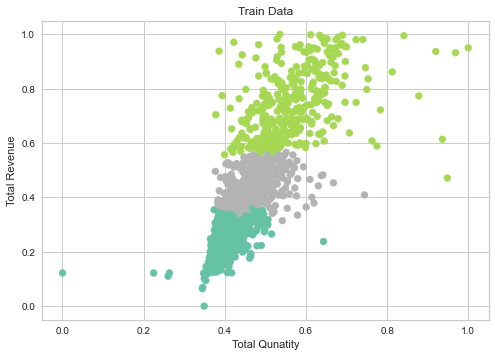

In [59]:
plt.scatter(train_points[:, 0], train_points[:, 1], c=AggModel_train.labels_, cmap='Set2')
plt.title('Train Data')                              
plt.xlabel('Total Qunatity')                        
plt.ylabel('Total Revenue')     
plt.show()

The following function is quoted form [official site](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [60]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)      
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.show()

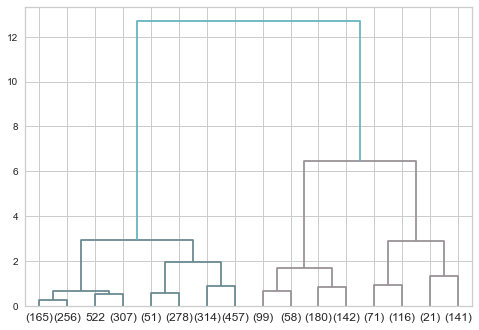

In [61]:
plot_dendrogram(AggModel_train, truncate_mode="level", p=3)

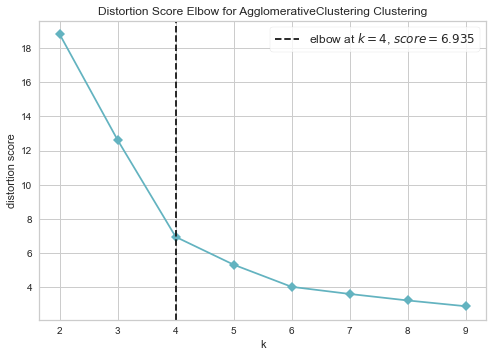

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
visualizer_test = KElbowVisualizer(AgglomerativeClustering(), k=(2, 10), timings=False)
visualizer_test.fit(test_points)
visualizer_test.show()

In [63]:
K = 4
AggModel_test = AgglomerativeClustering(n_clusters=K, affinity = 'euclidean', linkage = 'ward', compute_distances=True)
AggModel_test.fit(test_points)

AgglomerativeClustering(compute_distances=True, n_clusters=4)

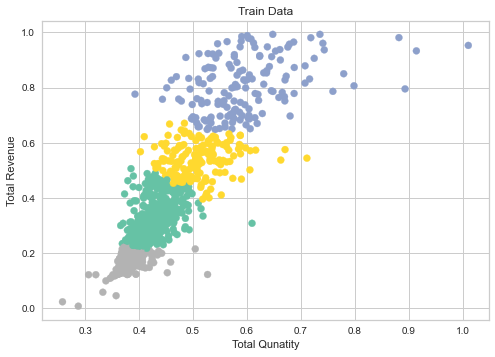

In [64]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=AggModel_test.labels_, cmap='Set2')
plt.title('Train Data')                              
plt.xlabel('Total Qunatity')                        
plt.ylabel('Total Revenue')     
plt.show()

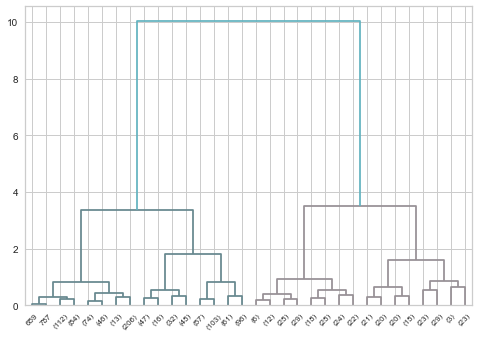

In [52]:
plot_dendrogram(AggModel_test, truncate_mode="level", p=4)

## Evaluate Kmeans

In [53]:
from sklearn.metrics.cluster import (adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score, completeness_score, pair_confusion_matrix,
    contingency_matrix, expected_mutual_information, homogeneity_completeness_v_measure, homogeneity_score, mutual_info_score, v_measure_score,
    fowlkes_mallows_score, entropy, silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score, consensus_score)

print("The Completeness score is %0.12f" % completeness_score(x_test['QuantityScaled'], kmeans_predicted))
print("Random score is %0.12f " % rand_score(x_test['QuantityScaled'], kmeans_predicted))
print("The normalized Mutual info score is %0.12f" %normalized_mutual_info_score( x_test['QuantityScaled'],kmeans_predicted))

The Completeness score is 0.990829231077
Random score is 0.674134374350 
The normalized Mutual info score is 0.317479196890


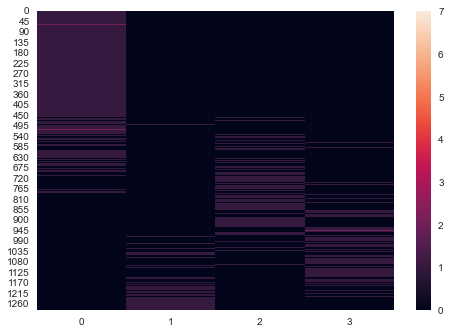

In [65]:
from sklearn.metrics.cluster import contingency_matrix
kmean_con = contingency_matrix(x_test['RevenueScaled'], kmeans_predicted)
sns.heatmap(kmean_con)
plt.show()

## Refrences
[link 1](https://scikit-learn.org/stable/modules/model_evaluation.html)<br>

[link 2](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)<br>

[link 3](https://www.datacamp.com/cheat-sheet/scikit-learn-cheat-sheet-python-machine-learning)<br>

[link 4](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad)

[link 5](https://github.com/microsoft/ML-For-Beginners/blob/main/5-Clustering/2-K-Means/README.md)

[link 6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2099486/)